# Exploration des Données - Online Retail II

Ce notebook présente l'analyse exploratoire du dataset Online Retail II. 

**Objectifs** :
- Comprendre la structure et la qualité des données.
- Analyser les distributions et les tendances.
- Réaliser une première analyse de cohortes et segmentation RFM.

---

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Configuration
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

## 1. Chargement et Synthèse des Données

In [9]:
# Chargement des données nettoyées
df = pd.read_csv('../data/processed/online_retail_cleaned.csv')
df.columns = df.columns.str.replace('ï»¿', '')  # Remove BOM character
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(f"Volume total : {df.shape[0]} lignes, {df.shape[1]} colonnes")
print(f"Période : du {df['InvoiceDate'].min()} au {df['InvoiceDate'].max()}")
df.head()

Volume total : 824364 lignes, 9 colonnes
Période : du 2009-12-01 07:45:00 au 2011-12-09 12:50:00


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


### Dictionnaire de Variables

| Variable | Type | Description |
|---|---|---|
| Invoice | Object | Numéro de facture. Si commence par 'C', c'est une annulation. |
| StockCode | Object | Code produit unique. |
| Description | Object | Nom du produit. |
| Quantity | Int | Quantité vendue par transaction. |
| InvoiceDate | Datetime | Date et heure de la transaction. |
| Price | Float | Prix unitaire (£). |
| Customer ID | Int | Identifiant unique du client. |
| Country | Object | Pays du client. |
| TotalAmount | Float | Montant total de la ligne (Quantity * Price). |

## 2. Qualité des Données

In [10]:
# Valeurs manquantes
print("Valeurs manquantes par colonne :")
print(df.isnull().sum())

# Doublons
print(f"\nNombre de doublons : {df.duplicated().sum()}")

# Annulations
n_cancelled = df[df['Invoice'].astype(str).str.startswith('C')].shape[0]
print(f"\nNombre d'annulations (Invoice commence par 'C') : {n_cancelled} ({n_cancelled/len(df):.2%})")

# Outliers (Prix et Quantité)
print("\nStatistiques descriptives (Quantity, Price) :")
print(df[['Quantity', 'Price']].describe())

Valeurs manquantes par colonne :
Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
TotalAmount    0
dtype: int64

Nombre de doublons : 26479

Nombre d'annulations (Invoice commence par 'C') : 18744 (2.27%)

Statistiques descriptives (Quantity, Price) :
            Quantity          Price
count  824364.000000  824364.000000
mean       12.414574       3.676800
std       188.976099      70.241388
min    -80995.000000       0.000000
25%         2.000000       1.250000
50%         5.000000       1.950000
75%        12.000000       3.750000
max     80995.000000   38970.000000

Nombre de doublons : 26479

Nombre d'annulations (Invoice commence par 'C') : 18744 (2.27%)

Statistiques descriptives (Quantity, Price) :
            Quantity          Price
count  824364.000000  824364.000000
mean       12.414574       3.676800
std       188.976099      70.241388
min    -80995.000000       0.000000
25%         2.000

## 3. Analyses Univariées et Distributions

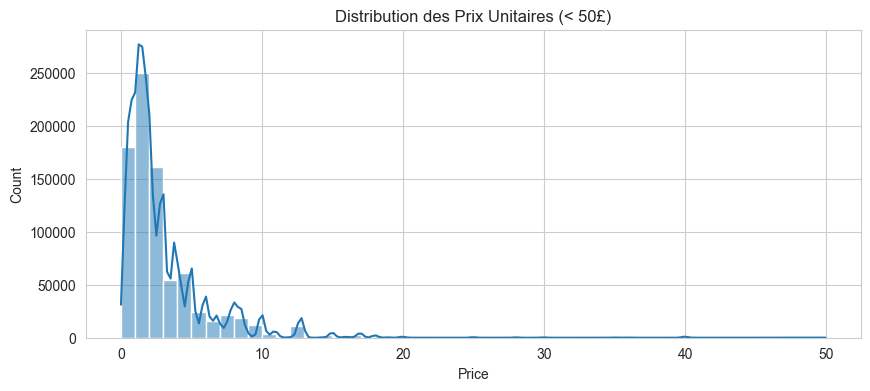

In [11]:
# Distribution des Prix (log scale pour lisibilité)
plt.figure(figsize=(10, 4))
sns.histplot(df[df['Price'] < 50]['Price'], bins=50, kde=True)
plt.title('Distribution des Prix Unitaires (< 50£)')
plt.show()

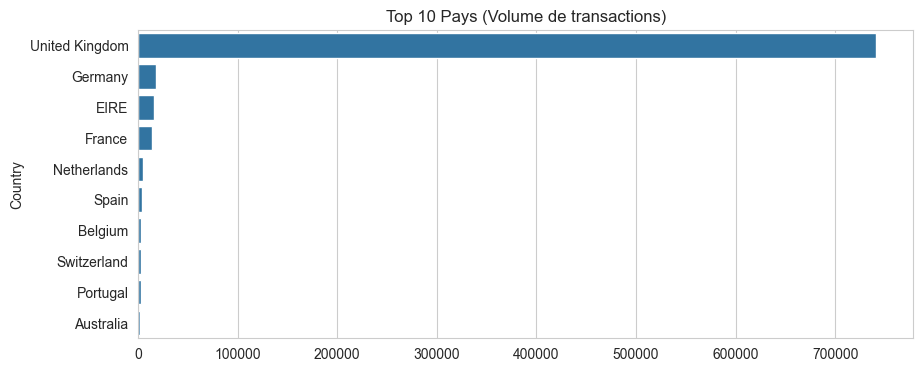

In [12]:
# Répartition par Pays (Top 10 hors UK pour lisibilité)
top_countries = df['Country'].value_counts().head(10)
plt.figure(figsize=(10, 4))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 10 Pays (Volume de transactions)')
plt.show()

## 4. Analyse Temporelle (Saisonnalité)

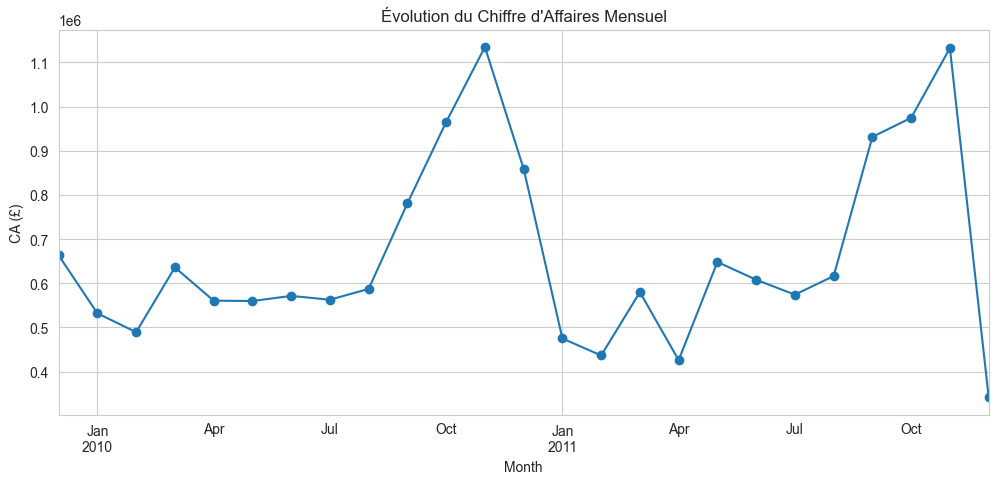

In [13]:
# Ventes mensuelles
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('Month')['TotalAmount'].sum()

plt.figure(figsize=(12, 5))
monthly_sales.plot(kind='line', marker='o')
plt.title('Évolution du Chiffre d\'Affaires Mensuel')
plt.ylabel('CA (£)')
plt.grid(True)
plt.show()

## 5. Analyse de Cohortes (Rétention)

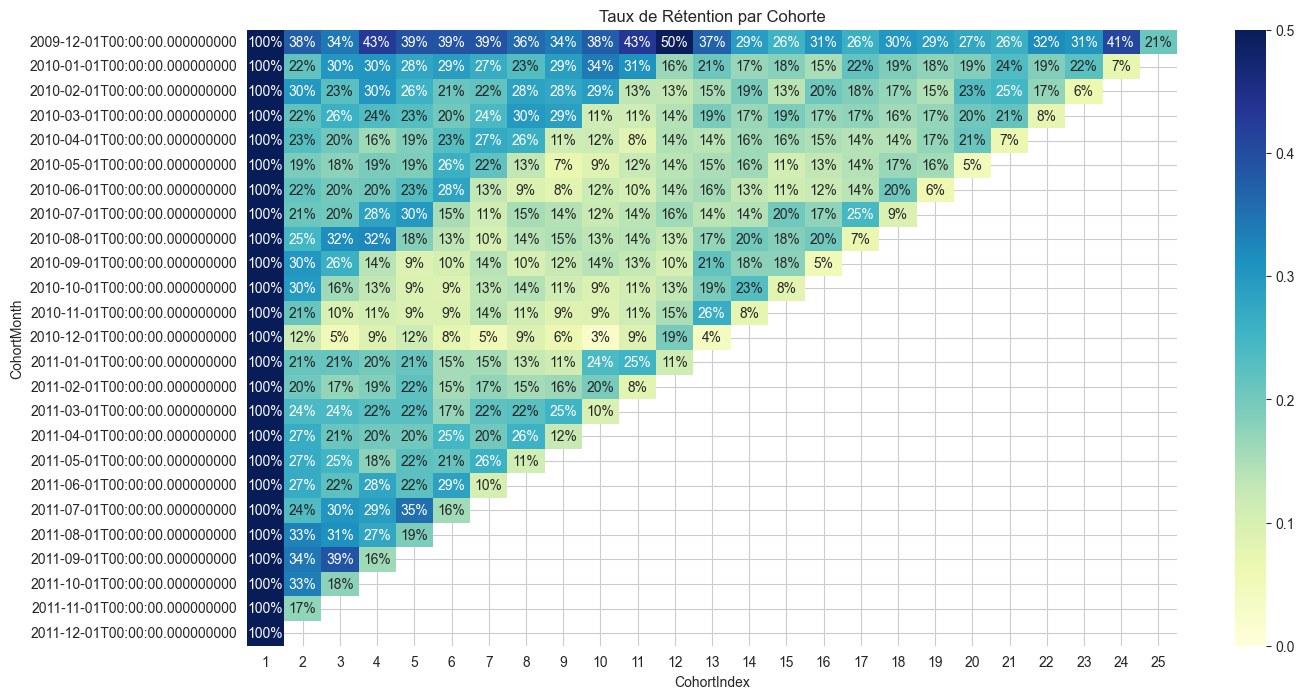

In [14]:
# Création des cohortes
def get_month(x): return pd.Timestamp(x.year, x.month, 1)
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
grouping = df.groupby('Customer ID')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')

def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

invoice_year, invoice_month = get_date_int(df, 'InvoiceMonth')
cohort_year, cohort_month = get_date_int(df, 'CohortMonth')
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
df['CohortIndex'] = years_diff * 12 + months_diff + 1

# Matrice de rétention
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Customer ID'].apply(pd.Series.nunique).reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Customer ID')
cohort_sizes = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

# Heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='YlGnBu', vmin=0.0, vmax=0.5)
plt.title('Taux de Rétention par Cohorte')
plt.show()

## 6. Segmentation RFM (Premier Aperçu)

In [15]:
# Calcul RFM
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalAmount': 'sum'
})
rfm.rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'TotalAmount': 'Monetary'}, inplace=True)

# Visualisation 3D (Recency vs Frequency vs Monetary)
fig = px.scatter_3d(rfm, x='Recency', y='Frequency', z='Monetary', opacity=0.5, title='Distribution RFM')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
fig.show()

## Conclusion et Prochaines Étapes
- Les données sont nettoyées et prêtes pour l'application.
- La saisonnalité est marquée (pics en fin d'année).
- La rétention diminue naturellement, mais certaines cohortes semblent plus performantes.
- La segmentation RFM permettra de cibler les actions.